# FLAI_Net Training

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import Dataset

In [162]:
ds = pd.read_csv('../dataset/flai_data.csv')
ds = ds.sort_values('label')
ds.head()

,user,label,coordinate 0,coordinate 1,coordinate 2,coordinate 3,coordinate 4,coordinate 5,coordinate 6,coordinate 7,...,coordinate 53,coordinate 54,coordinate 55,coordinate 56,coordinate 57,coordinate 58,coordinate 59,coordinate 60,coordinate 61,coordinate 62
0,moritz,a,0.730594,0.860723,-5.102247e-07,0.682833,0.852305,-0.014321,0.636179,0.788223,...,-0.003805,0.719923,0.701999,-0.016774,0.725298,0.744726,-0.007237,0.732716,0.759353,0.004919
21,moritz,a,0.757182,0.595954,-6.954833e-07,0.684799,0.574310,-0.013963,0.627625,0.496845,...,-0.002976,0.736522,0.372610,-0.022184,0.744411,0.430808,-0.009428,0.757286,0.458885,0.008159
20,moritz,a,0.766666,0.547899,-6.569658e-07,0.706994,0.541128,-0.007830,0.657069,0.477074,...,-0.007374,0.764765,0.389787,-0.019653,0.762536,0.440374,-0.008040,0.773210,0.452167,0.005038
19,moritz,a,0.806713,0.450147,-7.716191e-07,0.743366,0.417360,-0.012785,0.704203,0.330999,...,-0.014698,0.848655,0.269186,-0.029429,0.835300,0.325597,-0.015605,0.838689,0.347822,-0.000445
18,moritz,a,0.266952,0.681939,-3.637211e-07,0.311002,0.707136,-0.017852,0.370698,0.672354,...,-0.000278,0.316917,0.547948,-0.015398,0.300252,0.584826,-0.008061,0.289545,0.593305,0.002334


### Dataset Statistics

In [163]:
num_samples = len(ds)
num_contributors = len(pd.unique(ds.user))
classes = pd.unique(ds.label)
print(f'Samples: {num_samples}')
print(f'Unique contributors: {num_contributors}')
print(f'Classes: {classes}')

Samples: 486
Unique contributors: 1
Classes: ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's'
 't' 'u' 'v' 'w' 'x' 'y']


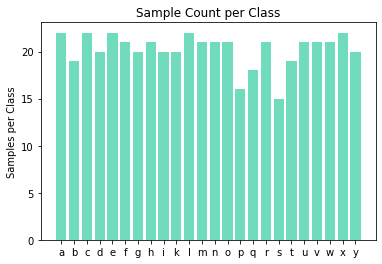

In [164]:
samples_per_label = ds.label.value_counts().sort_index()
color = (112/255, 219/255, 189/255)
x_pos = [i for i in range(len(samples_per_label.index))]
plt.bar(x_pos, samples_per_label, color=color)
plt.xticks(x_pos, samples_per_label.index)
plt.ylabel('Samples per Class')
plt.title('Sample Count per Class')
plt.show()

### Shuffle and Split Dataset

In [165]:
ds_y = ds.label.array
ds_y = pd.factorize(ds_y)[0]
ds_y = np.array(ds_y)

ds_x = ds.drop(['label', 'user'], axis=1)
ds_x = ds_x.to_numpy()

In [166]:
print(ds_y.shape)
print(ds_x.shape)

(486,)
(486, 63)


In [167]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(ds_x, ds_y, test_size=0.2, random_state=42)

In [168]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(388, 63)
(388,)
(98, 63)
(98,)


### Plot Vectors

In [169]:
data = [x_test, y_test]
data[0] = data[0].reshape(data[0].shape[0], 21, 3)
data[0].shape

(98, 21, 3)

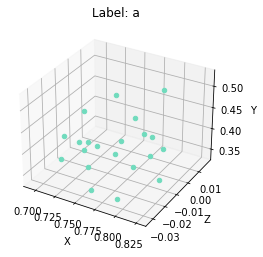

In [160]:
num = 10
example = data[0][num]
label = data[1][num]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for vec in example:
    ax.scatter(vec[0], vec[2], vec[1], c=[color])

plt.title(f'Label: {classes[label]}')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

plt.show()

## Train Neural Network

### Set Hyperparameters

In [130]:
epochs = 10
val_split = .2

### Labels to One Hot

In [131]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train.astype(int))
y_test = to_categorical(y_test.astype(int))

print(y_train.shape)
print(y_test.shape)

(388, 24, 2, 2)
(98, 24, 2, 2)


### Create Callbacks

In [132]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_acc',
                           restore_best_weights=True,
                           patience=3,
                           verbose=1)

### Create Model

In [133]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, AlphaDropout

model = Sequential(name="Model_1")

# ...

# model.summary()

### Train Model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                      epochs=epochs,
                      batch_size=64,
                      validation_split=val_split,
                      callbacks=[early_stop])

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()

### Save Model

In [ ]:
model.save(f'{model.name}.h5')

## Store Variables

In [ ]:
%store x_test
%store y_test
%store model.name

Stored 'x_test' (ndarray)
Stored 'y_test' (ndarray)


UsageError: Unknown variable 'model.name'
